![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_3/practica_8/practica_8.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica 8**

## **Segmentación Semántica**

## **Objetivos**
- Aprender a detectar objetos en contextos multi-etiqueta con segmentación semántica.
- Aprender nuevas arquitecturas.
- Crear funciones de pérdida y métricas personalizadas con la API de Keras.
- Profundizar un poco más sobre imágenes médicas.

## **Problema**
- En un hospital de Colombia se quiere automatizar el diagnóstico del cáncer de riñón utilizando Visión Artificial. Se consta con un dataset con riñones y tumores segmentados. Su labor como ingeniero es entrenar una red neuronal que permita automatizar este diagnóstico.

In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import os
from glob import glob

from tqdm.auto import tqdm

from google.colab import files

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from utils import general as gen
import cv2
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from typing import Optional, Any, List, Tuple, Union

from sklearn.model_selection import train_test_split

In [ ]:
SHAPE = (128, 128)
BATCH_SIZE = 64

In [ ]:
def get_labeled_image(
    img: Optional[np.ndarray], label: Optional[np.ndarray], 
    outline_color: Tuple[int] = (1, 0, 0), 
    color: Tuple[int] = (1, 0, 0), mode: str = "outer",
) -> Optional[np.ndarray]:
    """
    Function to get the labeled image
    :param img: The image to be labeled
    :type img: Optional[np.ndarray]
    :param label: The mask label to be applied
    :type label: Optional[np.ndarray]
    :param outline_color: The color of outline
    :type outline_color: Tuple[int]
    :param color: The color of fill
    :type color: Tuple[int]
    :return: The mask and the image merged
    :rtype: Optional[np.ndarray]
    """
    assert mode in ['thick', 'inner', 'outer', 'subpixel']
    img_mask = mark_boundaries(
        img, label, outline_color=outline_color, 
        color=color, mode=mode,
    )
    return img_mask

In [ ]:
train_id = "192V5FfehmbpN2wkl1apiygxSqW6EUmyP"
test_id = "1--hE7Ucvlsjf-fwET4-JMuS-VAva7Vxq"
unet_id = "1G5tMr19qcDPSpWQgS7Cj7M12GH-07BOg"

In [ ]:
gen.download_file_from_google_drive(train_id, "train.zip")
gen.download_file_from_google_drive(test_id, "test.zip")
gen.download_file_from_google_drive(unet_id, "unet.h5", dst="models")

0KB [00:00, ?KB/s]

  0%|          | 0/16555 [00:00<?, ?it/s]

Deleting File...


0KB [00:00, ?KB/s]

  0%|          | 0/1935 [00:00<?, ?it/s]

Deleting File...


0KB [00:00, ?KB/s]

In [ ]:
X_train_files = sorted(glob("data/train_data/data/*.npy"))
y_train_files = sorted(glob("data/train_data/labels/*.npy"))
train_files = np.array(list(zip(X_train_files, y_train_files)))

In [ ]:
X_test_files = sorted(glob("data/test_data/data/*.npy"))
y_test_files = sorted(glob("data/test_data/labels/*.npy"))
test_files = np.array(list(zip(X_test_files, y_test_files)))

In [ ]:
files_ = np.concatenate((test_files, train_files), axis=0)

## **Visualización y Análisis Exploratorio**
- En esta ocasión vamos a trabajar con el dataset de Kidney Tumor Segmentation donde vamos a detectar tumores en riñón usando segmentación semántica.
- Escala Hounsfield

![image](http://1.bp.blogspot.com/-apELBiPpN0g/UCa1sYUjT9I/AAAAAAAAABc/BcFCZE_eHbg/s400/4a11f2.jpg)

> Tomado de http://modulotecguana.blogspot.com/2012/08/la-escala-de-hounsfield.html

In [ ]:
np.random.seed(1234)
np.random.shuffle(files_)

In [ ]:
np.random.seed(1999)
random_sample = np.random.choice(range(len(files_)), 3)
random_sample

array([ 259, 5228, 7787])

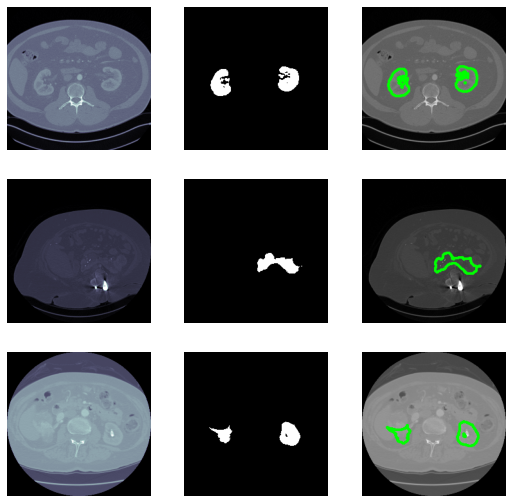

In [ ]:
plt.figure(figsize=(9, 9))

index = 1
for i in random_sample:
    path2img, path2lab = files_[i]
    
    X = np.load(path2img)
    y = np.load(path2lab)[..., 0]
    labeled_X = get_labeled_image(
        X, y, (0, 1, 0), 
        (0, 1, 0), "thick"
    )

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index + 1)
    gen.imshow(y, color=False)

    plt.subplot(3, 3, index + 2)
    gen.imshow(labeled_X)

    index += 3

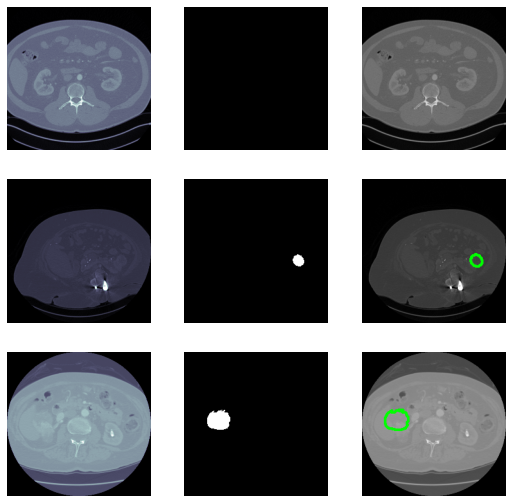

In [ ]:
plt.figure(figsize=(9, 9))

index = 1
for i in random_sample:
    path2img, path2lab = files_[i]
    
    X = np.load(path2img)
    y = np.load(path2lab)[..., 1]
    labeled_X = get_labeled_image(
        X, y, (0, 1, 0), 
        (0, 1, 0), "thick"
    )

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index + 1)
    gen.imshow(y, color=False)

    plt.subplot(3, 3, index + 2)
    gen.imshow(labeled_X)

    index += 3

In [ ]:
full_train, test = train_test_split(files_, test_size=0.2, random_state=1234)
train, val = train_test_split(full_train, test_size=0.2, random_state=1234)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train)
val_ds = tf.data.Dataset.from_tensor_slices(val)
test_ds = tf.data.Dataset.from_tensor_slices(test)

In [ ]:
for X_file, y_file in train_ds.take(2):
    tf.print(X_file, y_file)

"data/train_data/data/X_5342.npy" "data/train_data/labels/y_5342.npy"
"data/train_data/data/X_6090.npy" "data/train_data/labels/y_6090.npy"


In [ ]:
def process_file_path(
    X_file: tf.Tensor, 
    y_file: tf.Tensor,
) -> Optional[Tuple[tf.Tensor]]:
    """
    Function to load image and segmentation label
    :param X_file: The file of the image
    :type X_file: tf.Tensor
    :param y_file: The file of the segmentation label
    :type y_file: tf.Tensor
    :return: The image and segmentation 
    label loaded as numpy function
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    data = np.load(X_file)
    label = np.load(y_file)
    return data, label

def process_image(
    X: tf.Tensor, 
    y: tf.Tensor,
) -> Optional[Tuple[tf.Tensor]]:
    """
    Function to process image and segmentation label
    :param X: The image to be processed
    :type X: tf.Tensor
    :param y: The segmentation label to be processed
    :type y: tf.Tensor
    :return: The image and segmentation label loaded
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    X = tf.cast(X, tf.float32) / 255.
    y = tf.cast(y, tf.float32)
    # Set shape for numpy arrays
    X.set_shape(tf.TensorShape([None, None]))
    y.set_shape(tf.TensorShape([None, None, None]))
    X = tf.image.resize(X[..., tf.newaxis], SHAPE)
    y = tf.image.resize(
        y, SHAPE, 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )
    return X, y

def augment_data(
    X: tf.Tensor, 
    y: tf.Tensor,
):
    """
    Function to augment data
    :param X: The image to be augmented
    :type X: tf.Tensor
    :param y: The segmentation label of the image
    :type y: tf.Tensor
    :return: The data augmented
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    X = tf.image.random_contrast(X, 0.0, 1.0)
    X = tf.image.random_brightness(X, 0.2)
    return X, y

def performance(
    dataset: Optional[tf.data.Dataset], 
    train: bool = True
) -> Optional[tf.data.Dataset]:
    """
    Function to boost dataset load performance
    :param dataset: The dataset to be boosted
    :param type: Optional[tf.data.Dataset]
    :param train: Flag to indicate the nature of the dataset
    :param type: bool
    :return: The dataset boosted
    :rtype: Optional[tf.data.Dataset]
    """
    if train:
        # Shuffle the dataset to a fixed buffer sample
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        # The number of batches that will be parallel processed
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Repeat the incidences in the dataset
    dataset = dataset.repeat()
    # Create batches from dataset
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_ds = train_ds.map(
    lambda X_y_file: tf.numpy_function(
        process_file_path, 
        [X_y_file[0], X_y_file[1]], 
        [tf.uint8, tf.uint8]
    )
).map(process_image)

val_ds = val_ds.map(
    lambda X_y_file: tf.numpy_function(
        process_file_path, 
        [X_y_file[0], X_y_file[1]], 
        [tf.uint8, tf.uint8]
    )
).map(process_image)

test_ds = test_ds.map(
    lambda X_y_file: tf.numpy_function(
        process_file_path, 
        [X_y_file[0], X_y_file[1]], 
        [tf.uint8, tf.uint8]
    )
).map(process_image)

In [ ]:
# train_ds = train_ds.map(augment_data)

In [ ]:
TRAIN_SIZE = len(train_ds)
VAL_SIZE = len(val_ds)
TEST_SIZE = len(test_ds)

In [ ]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

In [ ]:
for X_batch, y_batch in train_ds.take(4):
    pass

In [ ]:
y_batch.shape

TensorShape([64, 128, 128, 2])

In [ ]:
np.unique(y_batch)

array([0., 1.], dtype=float32)

## **Modelamiento**
![image](https://docs.google.com/uc?export=download&id=1XAMvojRsVynBrqwcYLZgwzOnaFvmP2vc)

![image](https://docs.google.com/uc?export=download&id=1p1aDB6jtU9MDs25PiIwoDUjvYezc2llR)

> Tomado de: Atienza, R., 2020. *Advanced Deep Learning With Tensorflow 2 And Keras*. (513 pages) 2nd ed. United Kingdom: Packt Publishing.

### **U-Net**

![image](https://www.researchgate.net/profile/Olaf_Ronneberger/publication/276923248/figure/fig4/AS:639578838929408@1529498886425/U-net-architecture-example-for-32x32-pixels-in-the-lowest-resolution-Each-blue-box.png)

In [ ]:
def conv_block(
    n_filters: int, kernel: int = 3, padding: str = "same", 
    strides: int = 1, activation: str = "leaky_relu", 
    bn: bool = True, *args: Union[Tuple[Any], Any], 
    **kwargs: Union[dict, Any],
):
    sequential = keras.Sequential()
    if kwargs.get("input_shape"):
        sequential.add(
            keras.layers.Conv2D(
                n_filters, kernel_size=kernel, padding=padding, 
                strides=strides, activation=activation,
                input_shape=kwargs.get("input_shape"),
            )
        )
    else:
        sequential.add(
            keras.layers.Conv2D(
                n_filters, kernel_size=kernel, padding=padding, 
                strides=strides, activation=activation,
            )
        )
    if bn:
        sequential.add(
            keras.layers.BatchNormalization()
        )
    return sequential


def upsample_block(
    pool_size: int = 2,
    data_format=None, 
    *args: Union[Tuple[Any], Any], 
    **kwargs: Union[dict, Any],
):
    return keras.layers.UpSampling2D(
        size=pool_size,
        data_format=data_format,
        interpolation="bilinear"
    )


class DownBlock(keras.Model):
    def __init__(
        self, n_filters: int, 
        *args: Union[Tuple[Any], Any], 
        **kwargs: Union[dict, Any],
    ):
        super(DownBlock, self).__init__()

        self.sequential = keras.Sequential()

        jump = kwargs.get("jump", 2)

        for _ in range(jump):
            self.sequential.add(conv_block(n_filters, *args, **kwargs))

    def call(self, inputs):
        return self.sequential(inputs)


class UpBlock(keras.Model):
    def __init__(
        self, 
        n_filters, 
        *args: Union[Tuple[Any], Any], 
        **kwargs: Union[dict, Any],
    ):
        super(UpBlock, self).__init__()

        jump = kwargs.get("jump", 2)

        self.sequential = keras.Sequential()

        self.upsample = upsample_block(*args, **kwargs)

        for _ in range(jump):
            self.sequential.add(conv_block(n_filters, *args, **kwargs))

    def call(
        self, 
        down_inputs: tf.Tensor, 
        last_inputs: tf.Tensor,
    ) -> tf.Tensor:
        """
        Function to forward pass
        :param down_inputs: The weights from the down block
        :type down_inputs: tf.Tensor
        :param last_inputs: The weights from the last block
        :type last_inputs: tf.Tensor
        :return: The tensor resulting from the forward pass
        :rtype: tf.Tensor
        """
        last_inputs = self.upsample(last_inputs)
        x = tf.concat([last_inputs, down_inputs], axis=-1)
        return self.sequential(x)


class UNet(keras.Model):

    def __init__(
        self, input_shape: Tuple[int], 
        init_filters: int, 
        output_channels: int,
        depth: int, output_activation: str = "sigmoid", 
        *args: Union[Tuple[Any], Any], 
        **kwargs: Union[dict, Any],
    ):
        super(UNet, self).__init__()

        # Depth must be greater than one
        assert depth > 1, f"Depth must be greater than one"
        
        # Down and up blocks
        self.down_blocks = []
        self.up_blocks = []

        # Keyword arguments
        pool_size = kwargs.get("pool_size", 2)
        pool_stride = kwargs.get("pool_stride", 2)

        self.input_layer = conv_block(
            init_filters, 
            input_shape=input_shape, 
            *args, **kwargs,
        )

        current_filters = init_filters

        down_block = DownBlock(current_filters, *args, **kwargs)
        self.down_blocks.append(down_block)

        for _ in range(depth - 1):
            current_filters *= 2
            pool_layer = keras.layers.MaxPool2D(
                pool_size=pool_size, 
                strides=pool_stride,
            )
            self.down_blocks.append(pool_layer)

            down_block = DownBlock(
                current_filters, *args, **kwargs,
            )
            self.down_blocks.append(down_block)
        
        for _ in range(depth - 1):
            up_block = UpBlock(current_filters // 2, *args, **kwargs)
            self.up_blocks.append(up_block)
            current_filters //= 2

        self.output_layer = conv_block(
            n_filters=output_channels, kernel=1,
            activation=output_activation, 
            padding="valid", bn=False,
        )

    def call(
        self, inputs: tf.Tensor,
    ) -> tf.Tensor:
        x = self.input_layer(inputs)
        down_tensors = []

        for idx, block in enumerate(self.down_blocks):
            x = block(x)
            if isinstance(block, DownBlock):
                down_tensors.append(x)

        for idx, block in enumerate(self.up_blocks):
            idx_block = -(idx + 2)
            x = block(down_tensors[idx_block], x)

        return self.output_layer(x)

In [ ]:
class JaccardMetric(keras.metrics.Metric):
    def __init__(
        self, 
        name: str = "IoU", 
        epsilon: float = 1e-5, 
        **kwargs: Union[Dict, Any],
    ):
        super(JaccardMetric, self).__init__(name=name, **kwargs)
        self.batch_jaccard = self.add_weight(
            name="jaccard", 
            initializer="zeros",
        )
        self.count = self.add_weight(
            name="count",
            initializer="zeros",
        )
        self.epsilon = epsilon

    def update_state(
        self, y_true: tf.Tensor, 
        y_pred: tf.Tensor, sample_weight=None,
    ):
        axis = (1, 2)
        inter = tf.reduce_sum(y_true * y_pred, axis=axis)
        union = (
            tf.reduce_sum(y_true, axis=axis) 
            + tf.reduce_sum(y_pred, axis=axis)
        )
        union -= inter
        IoU = tf.reduce_mean(
            (inter + self.epsilon) / (union + self.epsilon)
        )
        self.batch_jaccard.assign_add(IoU)
        self.count.assign_add(1)
    
    def result(self):
        return self.batch_jaccard / self.count


class JaccardLoss(keras.losses.Loss):
    def __init__(
        self, 
        epsilon: float = 1e-5, 
        **kwargs: Union[Dict, Any],
    ):
        super(JaccardLoss, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(
        self, 
        y_true: tf.Tensor, 
        y_pred: tf.Tensor,
    ):
        axis = (1, 2)
        inter = tf.reduce_sum(y_true * y_pred, axis=axis)
        union = (
            tf.reduce_sum(y_true, axis=axis) 
            + tf.reduce_sum(y_pred, axis=axis)
        )

        union -= inter

        IoU = 1 - tf.reduce_mean(
            (inter + self.epsilon) / (union + self.epsilon)
        )

        return IoU

In [ ]:
input_layer = keras.Input(shape=(*SHAPE, 1))
model = UNet(
    (*SHAPE, 1), 
    16, 2, 5, 
    jump=2, 
    bn=True, 
    pool_size=2,
)

In [ ]:
lr = 1e-4
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr), 
    loss=JaccardLoss(),
    metrics=[JaccardMetric()]
)

model.build(input_shape=(1, 128, 128, 1))

In [ ]:
model.load_weights("models/unet.h5")

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "models/weights.h5"

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(
        self, 
        weights_dir: str, 
        patience: int = 10, 
        rate: float = 0.5,
        best_loss: float = np.Inf,
        best_weights: Optional[List[np.ndarray]],
    ):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

        self.best_loss = best_loss

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        """
        self.wait = 0
        self.best_weights = self.model.get_weights()
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :para type: int
        :param logs: The logs from the output from an epoch ended
        :param type: dict
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        if current_loss < self.best_loss:
            # We save the model weights
            # We wait again
            # We assign the best loss and the best recall.
            self.wait = 0
            self.best_loss = current_loss
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")

In [ ]:
train_params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 1,
    "validation_data": val_ds,
    "callbacks": [
        CustomCallback(
            weights_dir, patience=10, best_loss=0.1057,
        ),
    ],
}

In [ ]:
model.fit(train_ds, **train_params)

In [ ]:
model.evaluate(test_ds, steps=TEST_SIZE // BATCH_SIZE)

28/28 [==============================] - 7s 239ms/step - loss: 0.1054 - IoU: 0.8946


[0.10539807379245758, 0.8946019411087036]

In [ ]:
files.download("models/weights.h5")

In [ ]:
for X_test_batch, y_test_batch in test_ds.take(1):
    break

In [ ]:
np.random.seed(None)
imgs = []
true_labels = []
for _ in range(3):
    rand_int = np.random.randint(0, len(X_test_batch))
    imgs.append(X_test_batch[rand_int].numpy())
    true_labels.append(y_test_batch[rand_int].numpy())

imgs = np.array(imgs)
true_labels = np.array(true_labels)

In [ ]:
predicted_labels = model.predict(imgs)

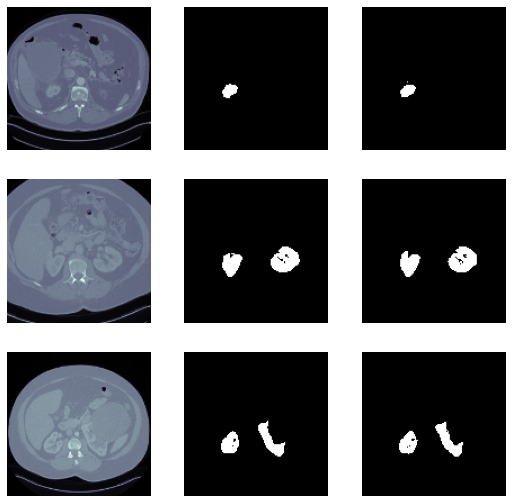

In [ ]:
plt.figure(figsize=(9, 9))

index = 1
for i in range(3):
    X = imgs[i].squeeze()
    y_pred = predicted_labels[i][..., 0] > 0.5
    y_true = true_labels[i][..., 0]

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index+1)
    gen.imshow(y_pred, color=False)

    plt.subplot(3, 3, index+2)
    gen.imshow(y_true, color=False)

    index += 3

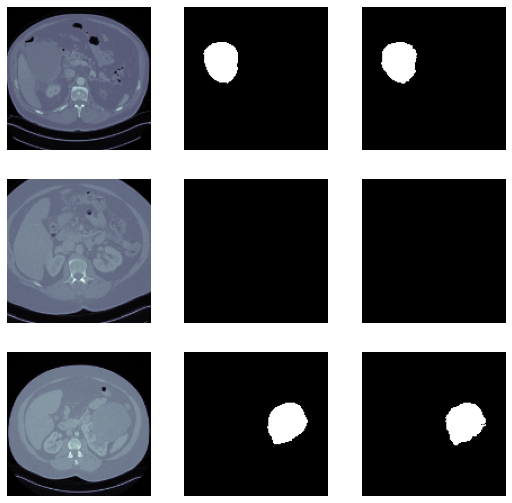

In [ ]:
plt.figure(figsize=(9, 9))

index = 1
for i in range(3):
    X = imgs[i].squeeze()
    y_pred = predicted_labels[i][..., 1] > 0.5
    y_true = true_labels[i][..., 1]

    plt.subplot(3, 3, index)
    gen.imshow(X, color=False, cmap="bone")

    plt.subplot(3, 3, index+1)
    gen.imshow(y_pred, color=False)

    plt.subplot(3, 3, index+2)
    gen.imshow(y_true, color=False)

    index += 3